In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

In [5]:
# convert raw .dat file to  csv using curate_db.py
# file has to exist in db/udb_1yr.dat
# !python curate_db.py 

## Import and Curate Dataframe

In [6]:
all_dat = pd.read_csv('./curated.csv', index_col=0)

# sift out pwrs
all_dat = all_dat.loc[all_dat['reactor_type'] == 'PWR']  
all_dat = sklearn.utils.shuffle(all_dat)
# only get assemblies with enrichment bigger than 1.5 and bunrup higher than 10,000
all_dat = all_dat.loc[(all_dat['init_enr'] > 1.5) & (all_dat['bu'] > 10000)]

# separate training and testing set
row_num = all_dat.shape[0]
cutoff = int(row_num * 0.6)
train_dat = all_dat.iloc[:cutoff, :]
test_dat = all_dat.iloc[cutoff:, :]


## Categorize Isotopes

In [7]:
# get all the isotopes, sorted by A
def get_name(f):
    z = ''
    for i in f:
        if i.isalpha():
            z += i
    return z

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

iso_list = list(train_dat)[4:]
# set the isotopes to categories:
fp = []
bred_fissile = []
u235 = []
nottru = []
tru = []

for iso in iso_list:
    if iso == 'u-235':
        u235.append(iso)
    elif iso in ['pu-239', 'u-233']:
        bred_fissile.append(iso)
    elif get_a(iso) < 200:
        fp.append(iso)
    elif get_name(iso) in ['np', 'pu', 'am', 'cm']:
        tru.append(iso)
    else:
        nottru.append(iso)

category = {'u235': u235,
            'bred_fissile': bred_fissile,
            'fp': fp,
            'tru': tru,
            'nottru': nottru}

print(category)

{'u235': ['u-235'], 'bred_fissile': ['pu-239', 'u-233'], 'fp': ['zr-95', 'zr-93', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'nb-95', 'pd-107', 'pm-147', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cs-134', 'cs-135', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'ag-108m', 'ag-110m', 'c-14', 'ce-144', 'y-90', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126'], 'tru': ['pu-238', 'np-237', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'cm-248', 'cm-245', 'cm-244', 'cm-246', 'cm-247', 'am-241', 'am-243', 'cm-243', 'cm-242'], 'nottru': ['ra-226', 'pa-231', 'am-242m', 'cf-251', 'cf-249', 'ac-227', 'u-234', 'u-236', 'u-238', 'th-229', 'th-232', 'th-230', 'u-232']}


## Define regression algorithms

- From Sklearn:
    - linear regression
    - bayesian ridge
    - huber regressor
    - ridge
    - lasso
    - random forest
- From Keras:
    - neural network

In [8]:
algorithms = {'lin_least_square': linear_model.LinearRegression,
              'bayesianridge': linear_model.BayesianRidge,
              'huberregressor': linear_model.HuberRegressor,
              'ridge': linear_model.Ridge,
              'lasso': linear_model.Lasso}
    
def linear_regression(algorithm, xtrain, ytrain, xtest, ytest):
    al = algorithm()
    model = al.fit(xtrain, ytrain)
    model_err = (ytest - model.predict(xtest))**2
    return model, model_err

def poly_regression(xtrain, ytrain, xtest, ytest, deg=2):
    poly = sklearn.preprocessing.PolynomialFeatures(degree=deg)
    x_ = poly.fit_transform(xtrain)
    predict_ = poly.fit_transform(xtest)
    
    # remove polynomial orders that isn't necessary (optional)
    
    model = linear_model.LinearRegression()
    model.fit(x_, ytrain)
    
    prediction = model.predict(predict_)
    model_err = (ytest - prediction)**2
    return model, model_err
    

def random_forest(xtrain, ytrain, xtest, ytest,
                  estimators=1000, state=42):    
    # Instantiate model with 1000 decision trees
    model = RandomForestRegressor(n_estimators = estimators, random_state = state)
    # Train the model on training data
    model.fit(xtrain, ytrain)
    model_err = (ytest - model.predict(xtest))**2
    return model, model_err



## Find best model for each isotope
Train model where:

**features**: burnup, enrichment

**target**: composition of isotope

Find model that predicts the isotopic composition with smallest squared error for each isotope

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


zr-95


No handles with labels found to put in legend.


poly4
9.37644178074e-14


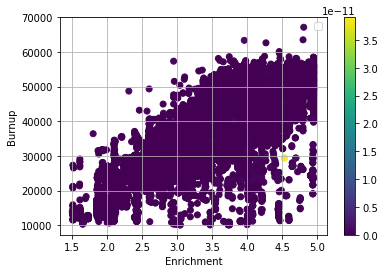

zr-93


No handles with labels found to put in legend.


poly3
3.43323070963e-11


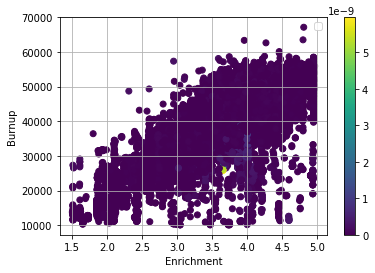

ra-226
Cant use  huberregressor


No handles with labels found to put in legend.


poly3
2.54137953454e-27


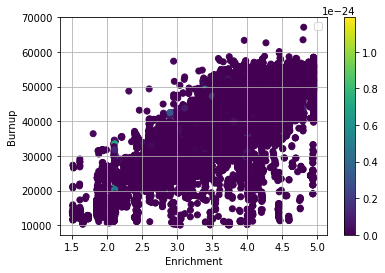

ru-103


No handles with labels found to put in legend.


poly3
2.85963473151e-16


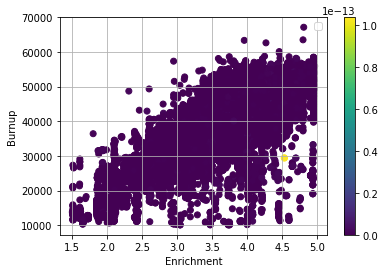

ru-106


No handles with labels found to put in legend.


poly3
2.47719708816e-10


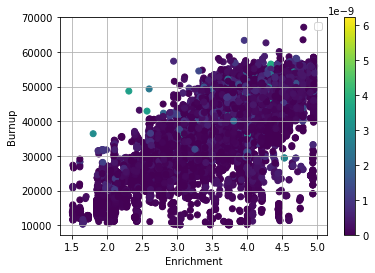

sb-124


No handles with labels found to put in legend.


poly4
3.24500741298e-20


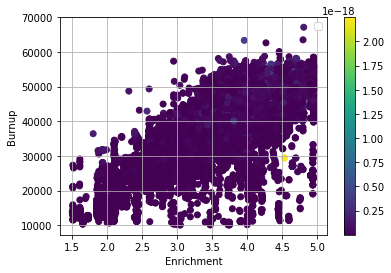

sb-125
poly3
1.43994725379e-12


No handles with labels found to put in legend.


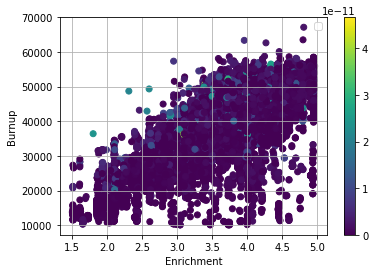

pu-238


No handles with labels found to put in legend.


poly4
8.7976907039e-10


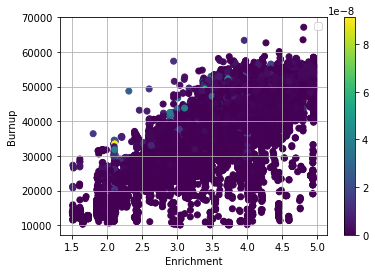

pu-239


No handles with labels found to put in legend.


random forest
1.59370510354e-07


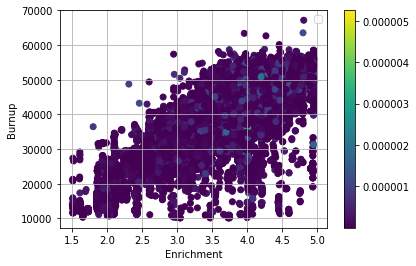

np-237


No handles with labels found to put in legend.


poly3
3.41760808277e-10


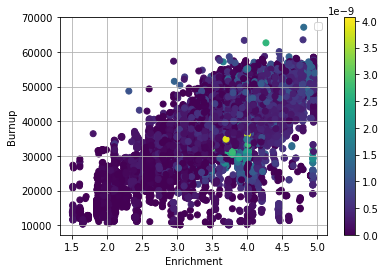

nb-95


No handles with labels found to put in legend.


poly4
1.3043593477e-13


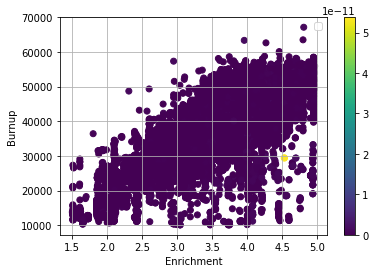

pa-231


No handles with labels found to put in legend.


poly5
4.5712466956e-20


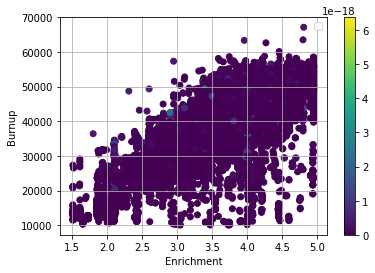

pd-107


No handles with labels found to put in legend.


poly3
1.21302623148e-11


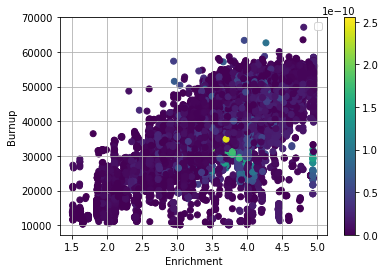

pm-147


No handles with labels found to put in legend.


poly3
2.05801045633e-10


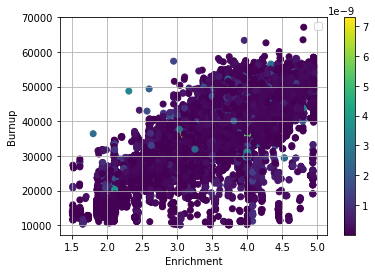

pu-240


No handles with labels found to put in legend.


poly3
4.58669031963e-09


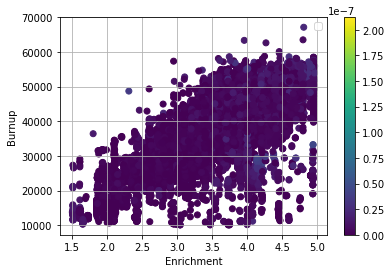

pu-241


No handles with labels found to put in legend.


poly3
9.36104640245e-09


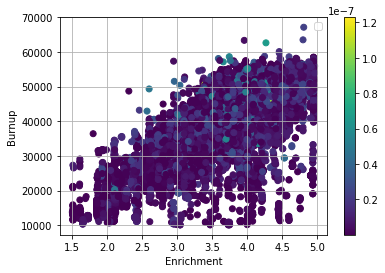

pu-244


No handles with labels found to put in legend.


poly4
4.84932186245e-17


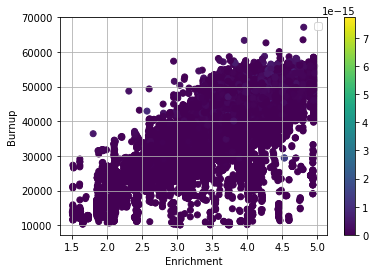

pu-242


No handles with labels found to put in legend.


poly3
2.0103999642e-10


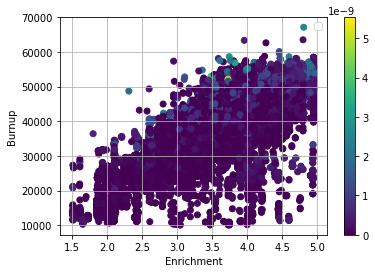

i-129


No handles with labels found to put in legend.


poly3
5.31502136201e-12


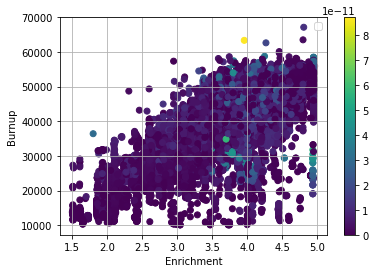

h-3


No handles with labels found to put in legend.


poly3
1.11490637426e-19


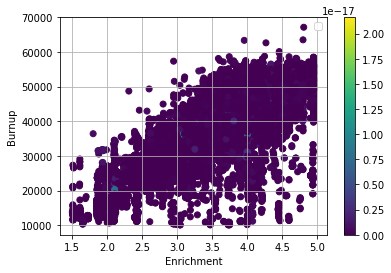

kr-85


No handles with labels found to put in legend.


poly4
9.92010000848e-12


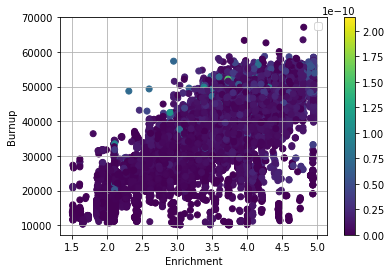

nb-94


No handles with labels found to put in legend.


poly3
3.62522107805e-20


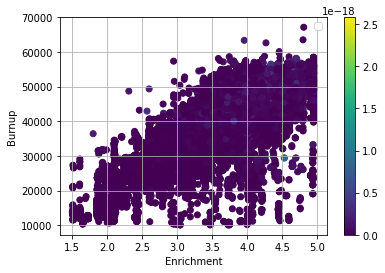

cm-248


No handles with labels found to put in legend.


poly5
2.37463887355e-20


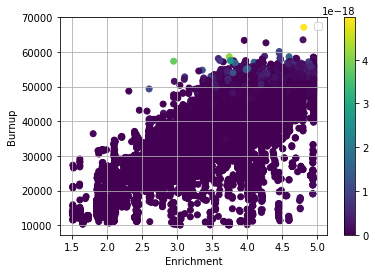

cs-134
poly4
1.32954866032e-10


No handles with labels found to put in legend.


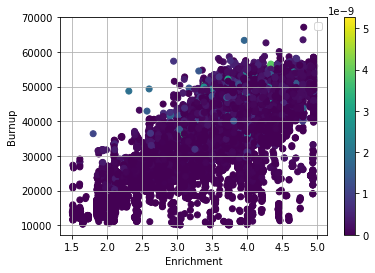

cs-135


No handles with labels found to put in legend.


poly3
7.52571214214e-09


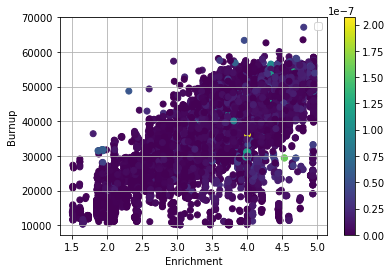

cm-245
poly5
6.13368664801e-13


No handles with labels found to put in legend.


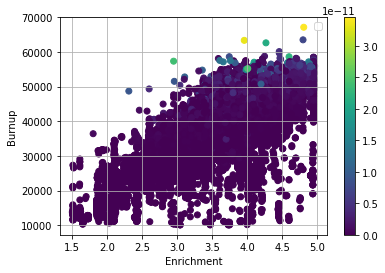

cm-244
poly4
9.48842830971e-12


No handles with labels found to put in legend.


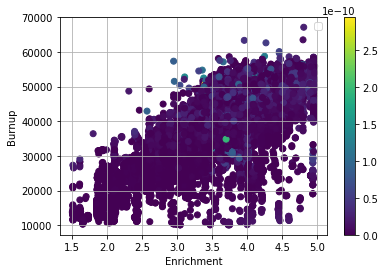

cm-246


No handles with labels found to put in legend.


poly5
2.01899323387e-15


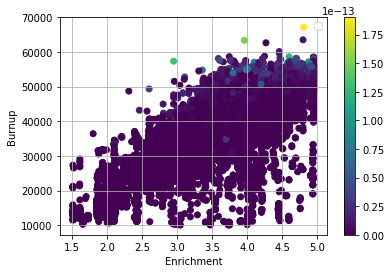

cm-247


No handles with labels found to put in legend.


poly5
2.03691556446e-18


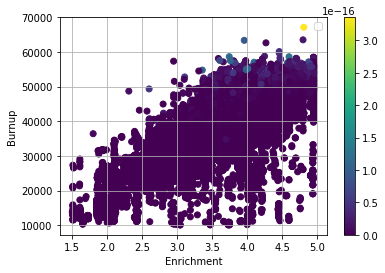

eu-152


No handles with labels found to put in legend.


poly3
6.67384818915e-17


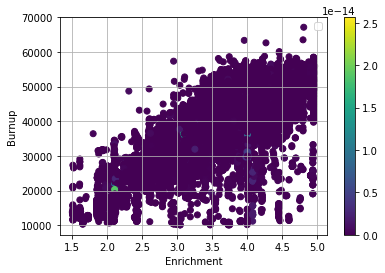

cs-137


No handles with labels found to put in legend.


poly3
7.51406205902e-10


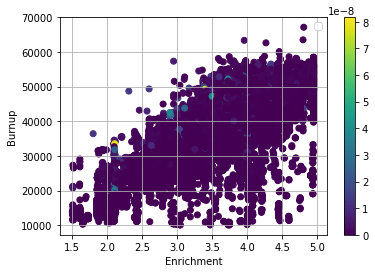

eu-154


No handles with labels found to put in legend.


poly4
2.97358170065e-12


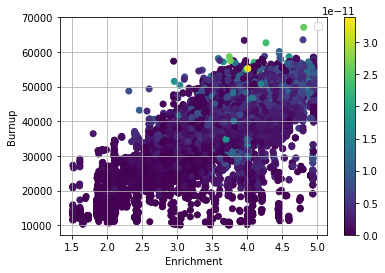

eu-155


No handles with labels found to put in legend.


poly3
2.61726742062e-14


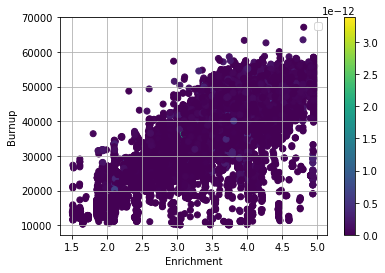

am-241


No handles with labels found to put in legend.


poly3
7.37927458386e-10


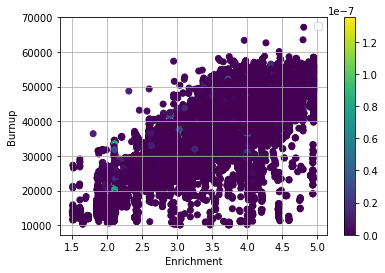

am-242m


No handles with labels found to put in legend.


poly4
2.65547005727e-13


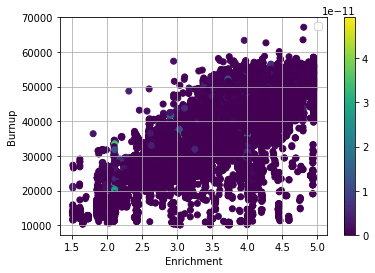

am-243


No handles with labels found to put in legend.


poly3
1.35323991263e-11


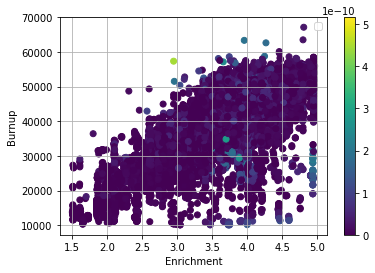

cf-251


No handles with labels found to put in legend.


poly5
4.62752445775e-25


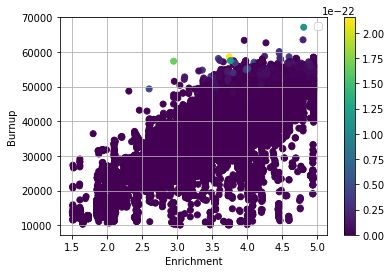

cf-249


No handles with labels found to put in legend.


poly5
7.75610975735e-24


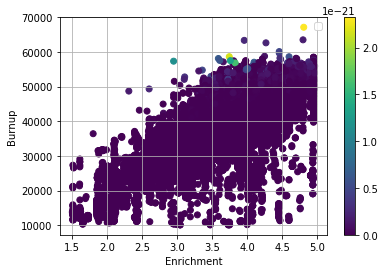

ag-108m


No handles with labels found to put in legend.


poly3
7.72427396335e-23


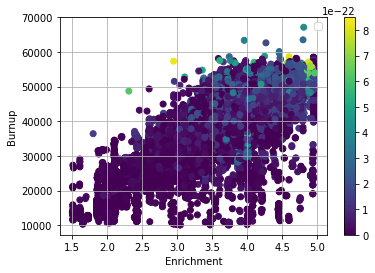

ag-110m


No handles with labels found to put in legend.


poly3
3.65940716372e-15


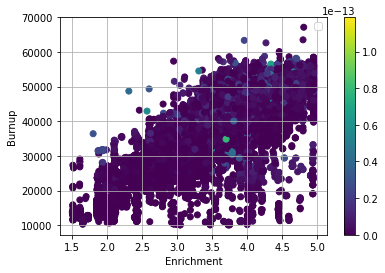

ac-227
poly5
1.92436420429e-28


No handles with labels found to put in legend.


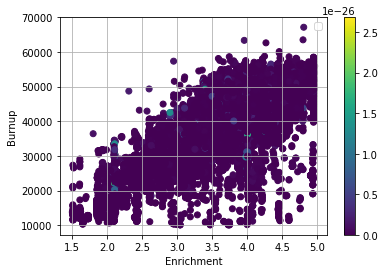

cm-243


No handles with labels found to put in legend.


poly3
6.42298962352e-14


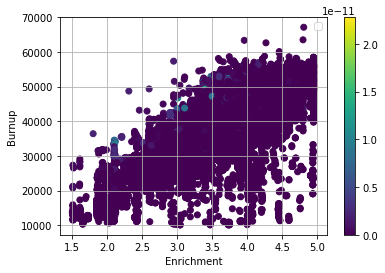

cm-242


No handles with labels found to put in legend.


poly3
2.96408951668e-12


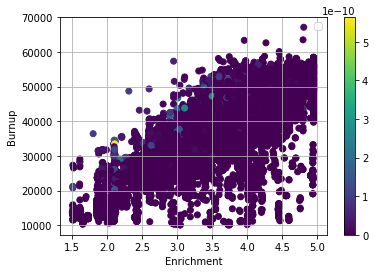

c-14


No handles with labels found to put in legend.


poly3
5.39726480628e-16


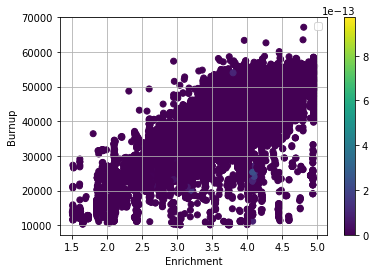

ce-144


No handles with labels found to put in legend.


poly5
9.89405272256e-10


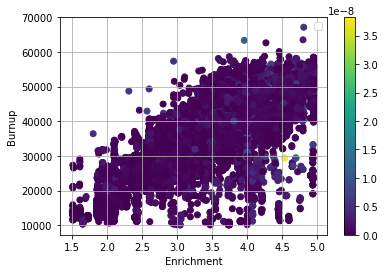

u-234


No handles with labels found to put in legend.


poly2
4.27296488523e-12


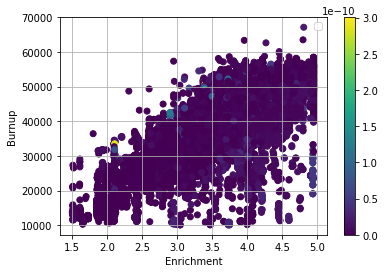

u-235


No handles with labels found to put in legend.


random forest
9.30649362081e-08


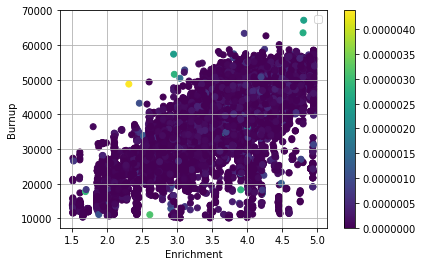

u-236


No handles with labels found to put in legend.


poly3
3.31900103857e-10


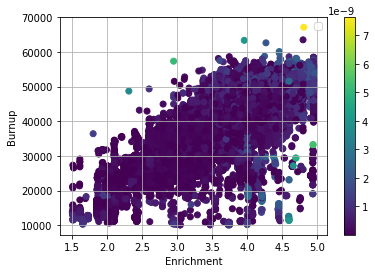

y-90


No handles with labels found to put in legend.


poly3
1.23781217351e-17


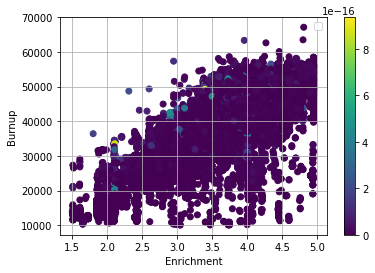

u-238


No handles with labels found to put in legend.


random forest
6.97314501597e-07


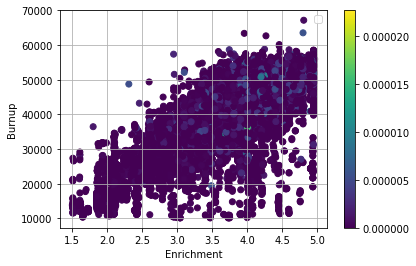

th-229


No handles with labels found to put in legend.


poly5
2.2481941155e-24


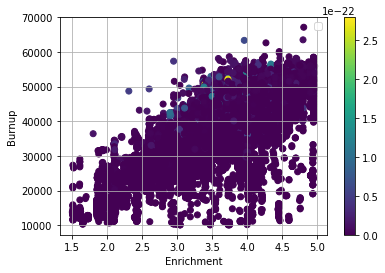

tc-99


No handles with labels found to put in legend.


poly3
1.95807788299e-11


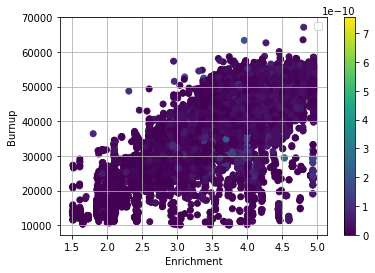

sm-151


No handles with labels found to put in legend.


poly4
1.07899341522e-12


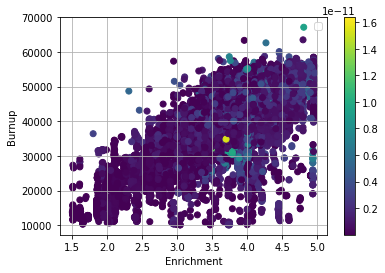

se-79


No handles with labels found to put in legend.


poly3
5.71619431326e-17


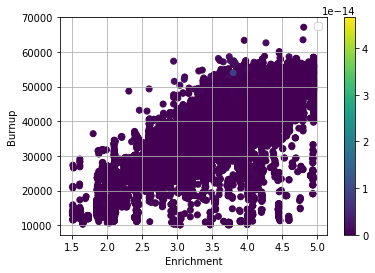

sr-90


No handles with labels found to put in legend.


poly3
1.92488326425e-10


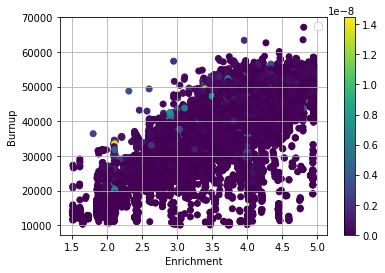

sn-126


No handles with labels found to put in legend.


poly3
6.31959568269e-14


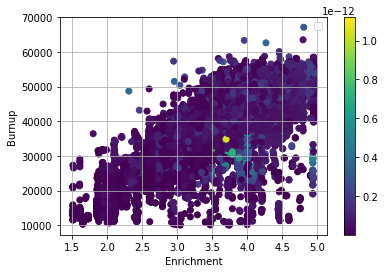

th-232


No handles with labels found to put in legend.


poly4
4.4947520567e-20


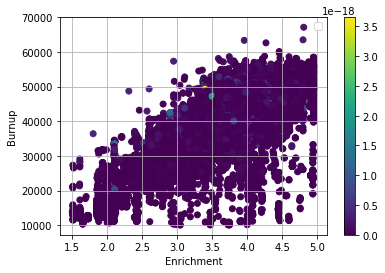

th-230
poly3
4.70433057273e-19


No handles with labels found to put in legend.


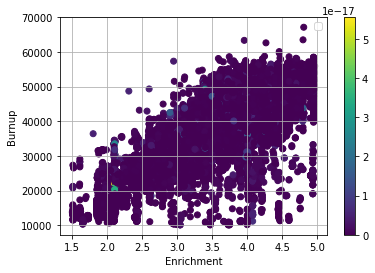

u-232


No handles with labels found to put in legend.


poly5
8.28201824964e-20


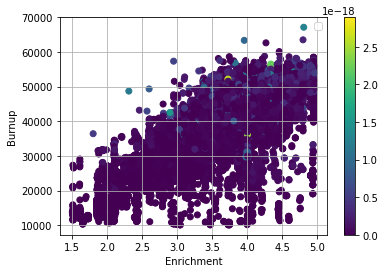

u-233


No handles with labels found to put in legend.


poly3
5.53786837468e-20


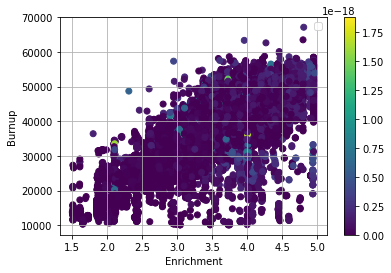

In [25]:
x_train = train_dat[['init_enr', 'bu']].as_matrix()
x_test = test_dat[['init_enr', 'bu']].as_matrix()
iso_err_dict = {}
alg_dict = {}
alg_str_dict = {}

for iso in iso_list:
    print(iso)
    err_dict = {}
    alg_buff = {}
    y_train = np.asarray(train_dat[iso])
    y_test = np.asarray(test_dat[iso])
    
    for key, val in algorithms.items():
        try:
            alg_buff[key], err_dict[key] = linear_regression(val, x_train, y_train, x_test, y_test)
        except:
            print('Cant use ', key)
    alg_buff['random forest'], err_dict['random forest'] = random_forest(x_train, y_train, x_test, y_test)
    alg_buff['poly2'], err_dict['poly2'] = poly_regression(x_train, y_train, x_test, y_test, deg=2)
    alg_buff['poly3'], err_dict['poly3'] = poly_regression(x_train, y_train, x_test, y_test, deg=3)
    alg_buff['poly4'], err_dict['poly4'] = poly_regression(x_train, y_train, x_test, y_test, deg=4)
    alg_buff['poly5'], err_dict['poly5'] = poly_regression(x_train, y_train, x_test, y_test, deg=5)

    
    mean_err_dict = {}
    for key, val in err_dict.items():
        mean_err_dict[key] = np.abs(np.mean(val))
    
    chosen_alg = min(mean_err_dict, key=mean_err_dict.get)
    print(chosen_alg)
    err = err_dict[chosen_alg]
    iso_err_dict[iso] = np.mean(err)
    alg_dict[iso] = alg_buff[chosen_alg]
    alg_dict[iso + '_alg'] = chosen_alg
    print(np.mean(err))
    
    plt.scatter(x_test[:,0], x_test[:,1], c=err)
    plt.xlabel('Enrichment')
    plt.ylabel('Burnup')
    plt.colorbar()
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()


## Two things:
- iso_err_dict
    - key: isotope
    - value: Mean error of model with test set
- alg_dict
    - key: isotope
    - value: tuple (algorithm name, fitted model object)

u-235
(41821, 2)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
-0.00080412184456


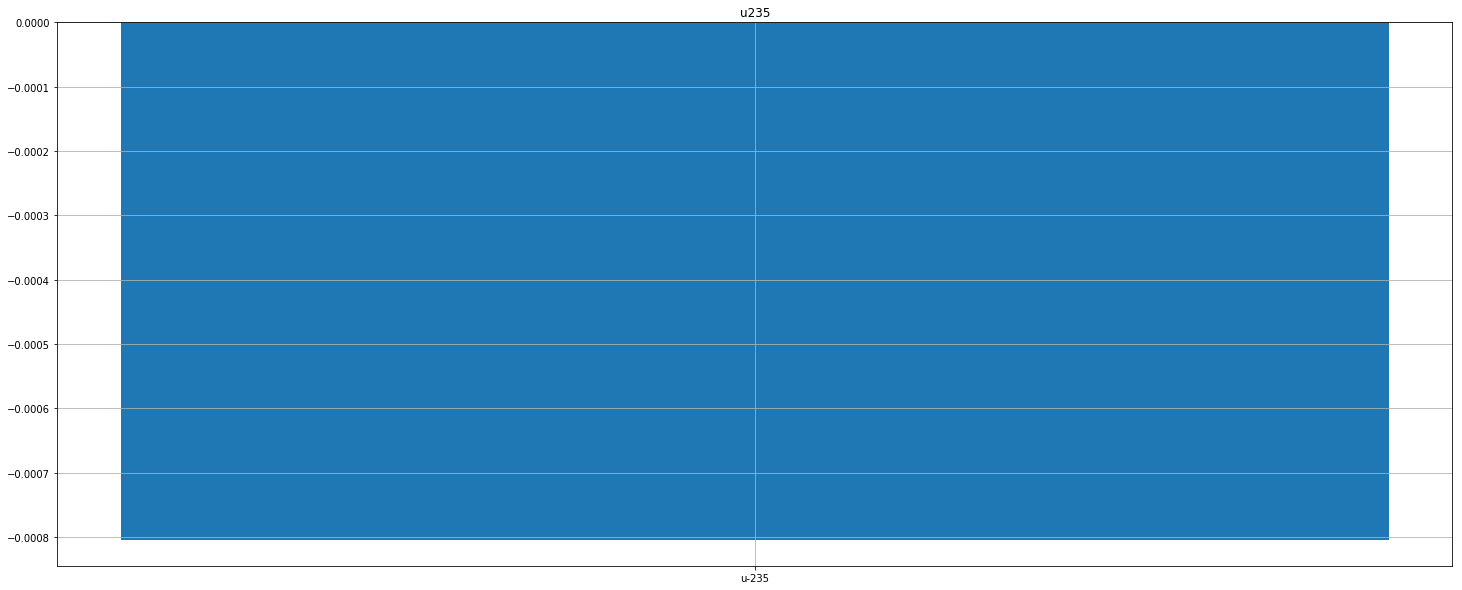

pu-239
(41821, 2)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
-0.00180009912026
u-233
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.00164477204715


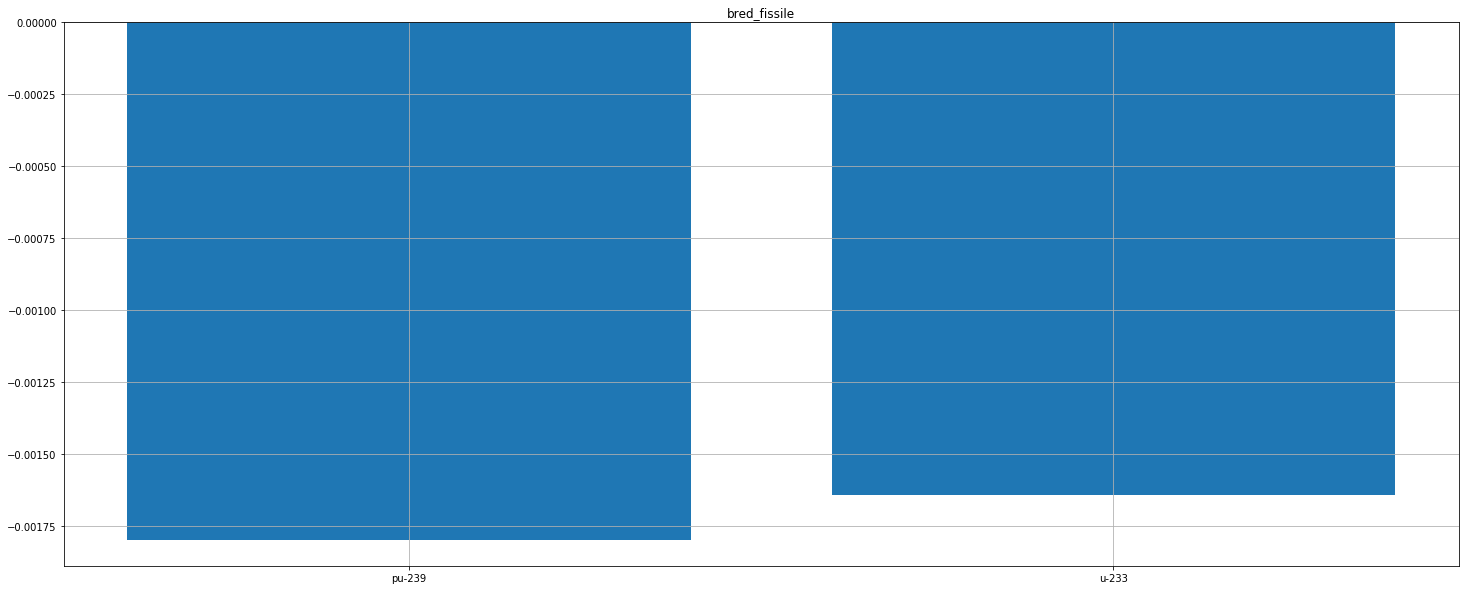

zr-95
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0574517154145
zr-93
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.000136935843019
ru-103
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0538350998195
ru-106
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0326521621321
sb-124
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0371520823873
sb-125
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0170237137824
nb-95
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0574630904542
pd-107
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.000133713077908
pm-147
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0117603

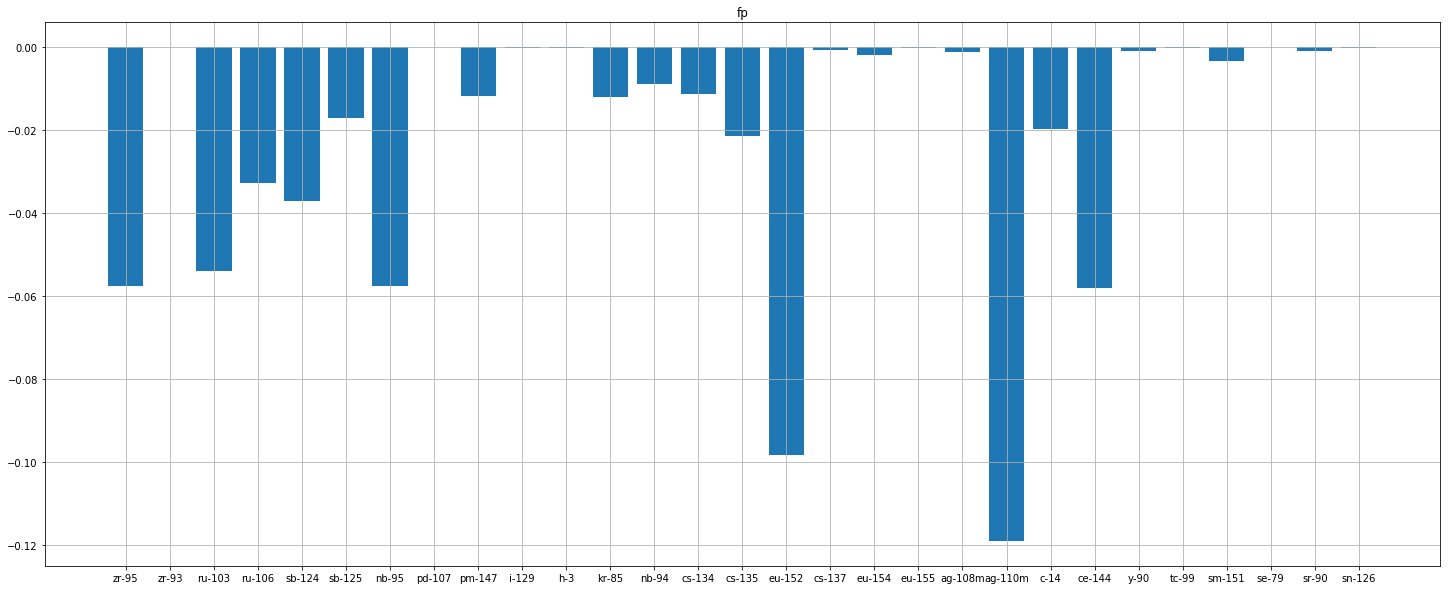

pu-238
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.00709199610678
np-237
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.000770485605442
pu-240
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.000410423822079
pu-241
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.00322056038389
pu-244
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0503209900251
pu-242
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.00016674108504
cm-248
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
49.034833042
cm-245
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.0873494282677
cm-244
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.0314

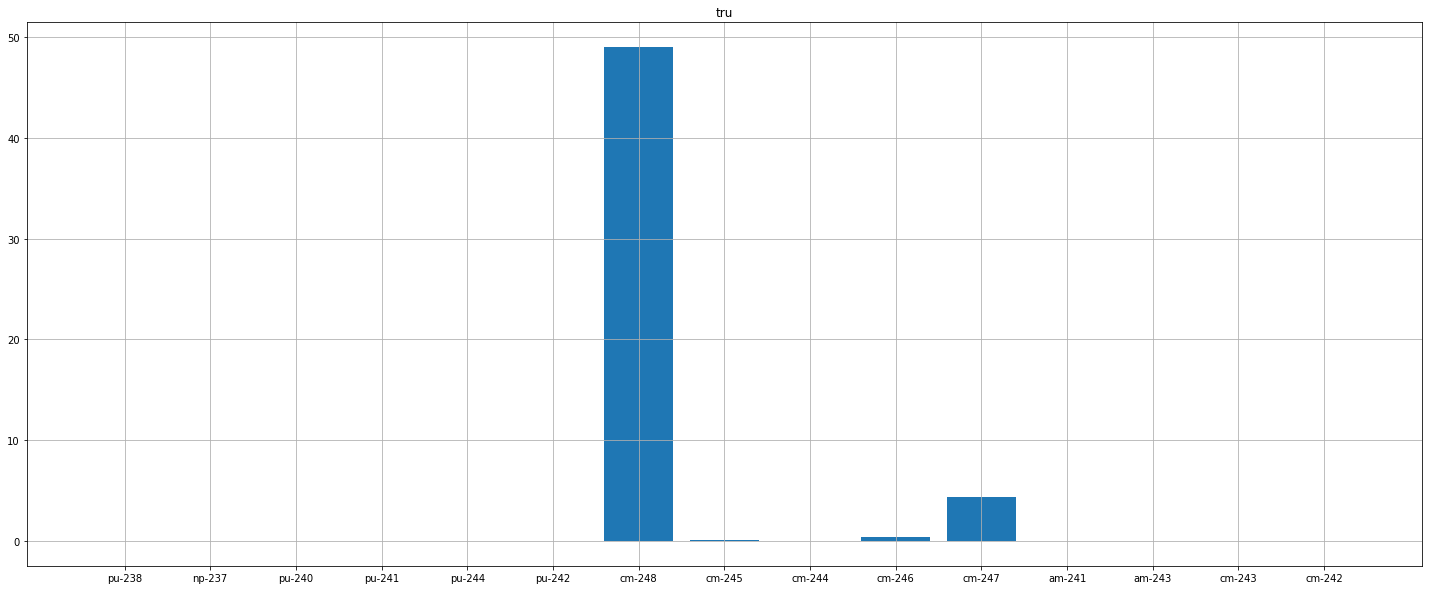

ra-226
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.291083483846
pa-231
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.089949469057
am-242m
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.11326875416
cf-251
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
1820.52674354
cf-249
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
298.116529538
ac-227
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.197969207263
u-234
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
-0.000132693136669
u-236
(41821, 2)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
0.00015585500879
u-238
(41821, 2)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='a

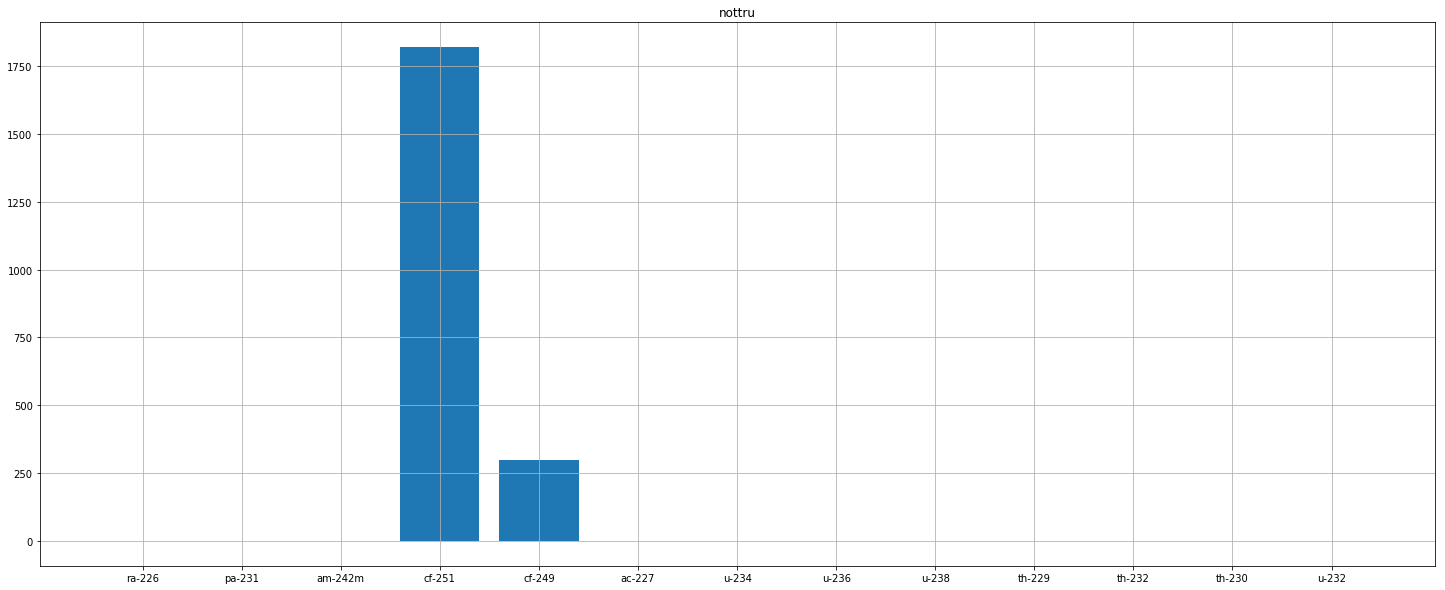

In [26]:
# use trained models to predict, and check percent error
for key, val in category.items():
    err_list = []
    for iso in val:
        y_test = np.asarray(test_dat[iso])
        print(iso)
        print(np.shape(x_test))
        print(alg_dict[iso])
        if any(i.isdigit() for i in alg_dict[iso + '_alg']):
            deg = get_a(alg_dict[iso + '_alg'])
            poly = sklearn.preprocessing.PolynomialFeatures(degree=deg)
            predicted = alg_dict[iso].predict(poly.fit_transform(x_test))
        else:
            predicted = alg_dict[iso].predict(x_test)
        err = (y_test - predicted) / y_test
        mean_err = np.mean(err)
        err_list.append(mean_err)
        print(mean_err)
    plt.figure(figsize=(25,10))
    plt.bar(val, err_list)
    plt.title(key)
    plt.grid()
    plt.show()
    plt.close()

## Pickle alg_dict to be used elsewhere

In [27]:
f = open('lin_dep.pkl', 'wb')
pickle.dump(alg_dict, f)
f.close()

MemoryError: 